In [173]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns

from constants import numeric_columns as num_cols


#in titanic
#   import math

In [174]:
#scaling, normalization
from sklearn.preprocessing import StandardScaler, MinMaxScaler

#kmeans, dbscan, hierarchical (sklearn)
from sklearn.cluster import DBSCAN

#in titanic fa con scipy
    #from scipy.cluster.hierarchy import linkage, dendrogram, fcluster

#vedere se serve
#evaluation
from sklearn.metrics import silhouette_score

#vedere se serve
#distance matrix (dbscan elbow, hierarchical)
from scipy.spatial.distance import pdist, squareform


In [175]:
df = pd.read_csv("pp_train.csv")
df.head()

,originalTitle,rating,startYear,endYear,runtimeMinutes,awardWins,numVotes,totalImages,totalVideos,totalCredits,...,is_Fantasy,is_Family,is_Mystery,is_Talk-Show,is_Drama,is_Sport,is_War,is_Horror,is_Animation,fill_runtimeMinutes
0,Neogenic Nightmare Chapter 3: Hydro-Man,8,1995,NaN,NaN,0.0,779,1,0,21,...,0,0,0,0,0,0,0,0,1,40.0
1,Looping,6,1982,NaN,NaN,0.0,11,1,0,1,...,0,0,0,0,0,0,0,0,0,28.0
2,Idealnaya para,6,1992,NaN,NaN,0.0,38,1,0,24,...,0,0,0,0,0,0,0,0,0,90.0
3,MasterChef Celebrity México,6,2021,NaN,NaN,0.0,15,22,0,56,...,0,0,0,0,0,0,0,0,0,31.0
4,Seutateueob,8,2020,2020.0,80.0,1.0,15718,347,2,47,...,0,0,0,0,1,0,0,0,0,80.0


In [176]:
#df["awardWins"].value_counts()

#### features

In [177]:
# no ->   'rating' (should be put as 1henc), 'canHaveEpisodes'(binary), 'isAdult' (binary), 'genres' (should be put as 1henc)

#1
features = df[['startYear', 'fill_runtimeMinutes', 'awardWins', 'numVotes', 'totalImages','totalVideos', 'totalCredits', 'criticReviewsTotal', 'awardNominationsExcludeWins','numRegions', 'userReviewsTotal']]

# senza 'awardWins','totalVideos','awardNominationsExcludeWins',
#features = df[['startYear', 'fill_runtimeMinutes', 'numVotes', 'totalImages', 'totalCredits', 'criticReviewsTotal', 'numRegions', 'userReviewsTotal']]

df_num = features.values

In [178]:
#presuppongo di voler fare poi i controlli cluster in abse a titletype
y = np.array(df['titleType']) 
#a way to define x and y; they are the numpy arrays of the dataset

y_map = {
    0: 'tvEpisode',
    1: 'videoGame',
    2: 'movie',
    3: 'tvSeries',
    4: 'video',
    5: 'tvMiniSeries',
    6: 'short',
    7: 'tvMovie',
    8: 'tvSpecial',
    9: 'tvShort'
}
y_mapped = pd.DataFrame(y).iloc[:,0].map(y_map)
#y is our target label; mapped into strings (y_map)

### Normalizzazioni

In [179]:
#LOGARITMICA
X = df_num.copy()
X = np.log1p(X)

In [180]:
# Z-SCORE
scaler = StandardScaler()   #inizialize the standard scaler
scaler.fit(X) #FIT the scaler on the data; x è la numpy matrix of the dataset
X_z_scal = scaler.transform(X) #TRANSFORM to have the scaled version


# MIN-MAX
scaler = MinMaxScaler()
X_minmax = scaler.fit_transform(X) #FIT e TRASFORM in una riga sola

##### scelgo normalizzazione

In [181]:
X_scal = X_z_scal

## DBSCAN

In [199]:
#initiialize and fit into data 

#1 con tutte le features
dbscan = DBSCAN(eps=1.55, min_samples=22)   #1.98 - 11 ,  2-22, 2 .12
    #2 senza le tre
#dbscan = DBSCAN(eps=0.26, min_samples=16)
dbscan.fit(X_scal)

#ORA -> standscale

DBSCAN(eps=1.55, min_samples=22)

In [200]:
dbscan.labels_ #get labels (classification of the diff clusters (-1 è il noise))
np.unique(dbscan.labels_, return_counts=True)
                #get labels e quanti points in ogni cluster

(array([-1,  0,  1,  2], dtype=int64),
 array([ 2235, 13079,   546,   571], dtype=int64))

In [184]:
""" 
sns.scatterplot(data=df,x="criticReviewsTotal", y="numVotes", 
                hue=dbscan.labels_, style=dbscan.labels_, palette="bright")
plt.show()
"""


' \nsns.scatterplot(data=df,x="criticReviewsTotal", y="numVotes", \n                hue=dbscan.labels_, style=dbscan.labels_, palette="bright")\nplt.show()\n'

#### Silhouette

In [201]:
print('Silhouette', silhouette_score(X_scal, dbscan.labels_)) #con noise cluster

print('Silhouette', silhouette_score(X_scal[dbscan.labels_ != -1], dbscan.labels_[dbscan.labels_ != -1]))  #senza noise

        # misura silh su DBSCAN LABELS la conta anche rispetto al noise cluster (-1) 
        # -> se non lo consid abbiamo valore + alto (i noise points sono lontani, lunghe distanze influenzano la silh) 
            # -> quando la misuro scartiamo anche noise così misuriamo risultato solo sui cluster

Silhouette 0.09172367580744857
Silhouette 0.13368062427486366


### kth neighbor distance

###### misuro distanze dal kth nearest n.

In [186]:
dist = pdist(X_scal, 'euclidean') 
dist = squareform(dist)

    #risultato -> array compresso con distanze per ogni coppia di punti nel dataset.

##### plotto le distanze ottenute

In [187]:
"""
k=4
kth_distances = []

for d in dist:  # d is a vector containing distances between the ith record and all the others
    index_kth_distance = np.argsort(d)[k]  # take the index of the kth nearest neighbor
    kth_distances.append(d[index_kth_distance])  # store the distance in a list


plt.plot(range(0, len(kth_distances)), sorted(kth_distances))
plt.ylabel('distance from the {}th neighbor'.format(k))
plt.grid(True, alpha=0.3)
plt.show()
 """

"\nk=4\nkth_distances = []\n\nfor d in dist:  # d is a vector containing distances between the ith record and all the others\n    index_kth_distance = np.argsort(d)[k]  # take the index of the kth nearest neighbor\n    kth_distances.append(d[index_kth_distance])  # store the distance in a list\n\n\nplt.plot(range(0, len(kth_distances)), sorted(kth_distances))\nplt.ylabel('distance from the {}th neighbor'.format(k))\nplt.grid(True, alpha=0.3)\nplt.show()\n "

##### misuro distanze dal kth, xth, yth nearest n.
###### utile se data is larger, provare con diversi valori di k (pox si rivelino clusters)

In [188]:
"""
ks = [11, 16, 22, 64]


fig = plt.figure(figsize=(16, 3)) # dimensions of the overall plot
fig_dims = (1, len(ks))

for i in range(len(ks)):
    k = ks[i]
    kth_distances = []

    for d in dist:  # d is a vector containing distances between the ith record and all the others
        index_kth_distance = np.argsort(d)[k]  # take the index of the kth nearest neighbor
        kth_distances.append(d[index_kth_distance])  # store the distance in a list

    plt.subplot2grid(fig_dims, (0, i))
    plt.plot(range(0, len(kth_distances)), sorted(kth_distances))
    plt.ylabel('distance from the {}th neighbor'.format(k))
    plt.grid(True, alpha=0.3)
             
#plt.tight_layout()
#fig, axes = plt.subplots(2, 3, figsize=(15, 10))
plt.show()
"""

"\nks = [11, 16, 22, 64]\n\n\nfig = plt.figure(figsize=(16, 3)) # dimensions of the overall plot\nfig_dims = (1, len(ks))\n\nfor i in range(len(ks)):\n    k = ks[i]\n    kth_distances = []\n\n    for d in dist:  # d is a vector containing distances between the ith record and all the others\n        index_kth_distance = np.argsort(d)[k]  # take the index of the kth nearest neighbor\n        kth_distances.append(d[index_kth_distance])  # store the distance in a list\n\n    plt.subplot2grid(fig_dims, (0, i))\n    plt.plot(range(0, len(kth_distances)), sorted(kth_distances))\n    plt.ylabel('distance from the {}th neighbor'.format(k))\n    plt.grid(True, alpha=0.3)\n             \n#plt.tight_layout()\n#fig, axes = plt.subplots(2, 3, figsize=(15, 10))\nplt.show()\n"

codice per trovare valore di eps automaticamente

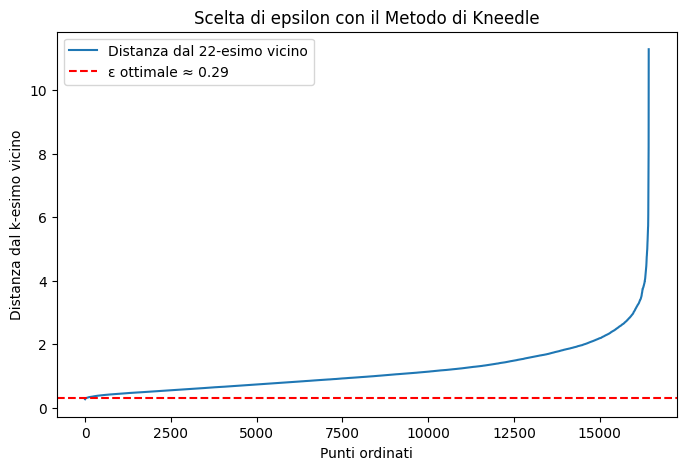

Valore ottimale di epsilon suggerito: 0.29


In [189]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
from kneed import KneeLocator

# Supponiamo che i tuoi dati siano in una matrice numpy 'X'
# Se hai un DataFrame pandas, usa X = df.values

# Imposta il valore di k (numero di vicini)
k = 22 # Basato sulle dimensioni del dataset

# Trova le distanze dei k vicini più vicini
nbrs = NearestNeighbors(n_neighbors=k).fit(X_scal)
distances, indices = nbrs.kneighbors(X_scal)

# Prendiamo la distanza del k-esimo vicino per ogni punto
k_distances = np.sort(distances[:, k - 1])  # Ordina in ordine crescente

# Trova il gomito con il metodo di Kneedle
kneedle = KneeLocator(range(len(k_distances)), k_distances, curve="concave", direction="increasing")
eps_optimal = kneedle.knee_y  # Valore ottimale di epsilon

# Plot delle distanze con il punto del gomito
plt.figure(figsize=(8, 5))
plt.plot(k_distances, label=f"Distanza dal {k}-esimo vicino")
plt.axhline(y=eps_optimal, color="r", linestyle="--", label=f"ε ottimale ≈ {eps_optimal:.2f}")
plt.xlabel("Punti ordinati")
plt.ylabel("Distanza dal k-esimo vicino")
plt.legend()
plt.title("Scelta di epsilon con il Metodo di Kneedle")
plt.show()

print(f"Valore ottimale di epsilon suggerito: {eps_optimal:.2f}")
